In [2]:
import json
import os

input_file = '/content/dataset_shingles_maria_sample.json'
output_dir = '/content/parts'
output_base = 'split_file_'
records_per_file = 200

os.makedirs(output_dir, exist_ok=True)

with open(input_file, 'r') as file:
    file_count = 0
    records = []

    for line in file:
        try:
            record = json.loads(line)
            records.append(record)

            if len(records) == records_per_file:
                output_file = os.path.join(output_dir, f'{output_base}{file_count}.jsonl')
                with open(output_file, 'w') as out_file:
                    for rec in records:
                        json.dump(rec, out_file)
                        out_file.write('\n')
                file_count += 1
                records = []
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

    if records:
        output_file = os.path.join(output_dir, f'{output_base}{file_count}.jsonl')
        with open(output_file, 'w') as out_file:
            for rec in records:
                json.dump(rec, out_file)
                out_file.write('\n')


Error decoding JSON: Unterminated string starting at: line 1 column 27279 (char 27278)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

class ShingleDataset(Dataset):
    def __init__(self, data, input_dim=130):
        self.data = data
        self.input_dim = input_dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        shingle_ids = [int(s) for s in item['shingle_id']]

        input_ids = torch.zeros(self.input_dim, dtype=torch.float32)
        input_ids[:len(shingle_ids)] = torch.tensor(shingle_ids[:self.input_dim], dtype=torch.float32)

        label = int(item['target'])
        return {'input_ids': input_ids, 'label': torch.tensor(label, dtype=torch.long)}

In [17]:
file_paths = ['/content/parts/split_file_0.jsonl', '/content/parts/split_file_1.jsonl']
dataframes = []
for file_path in file_paths:
    data = pd.read_json(file_path, lines=True)
    reshaped_data = [{'shingle_id': row['shingles'], 'target': int(row['target'])} for _, row in data.iterrows()]
    reshaped_df = pd.DataFrame(reshaped_data)
    dataframes.append(reshaped_df)

full_data = pd.concat(dataframes, ignore_index=True)

train_data = full_data.sample(frac=0.8, random_state=42)
val_data = full_data.drop(train_data.index)

train_dataset = ShingleDataset(train_data)
val_dataset = ShingleDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return self.fc(x)

In [19]:
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        logits = self.classifier(encoded)
        return logits, reconstructed

In [20]:
model = AutoencoderClassifier(input_dim=130, hidden_dim=64)
criterion_reconstruction = nn.MSELoss()
criterion_classification = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

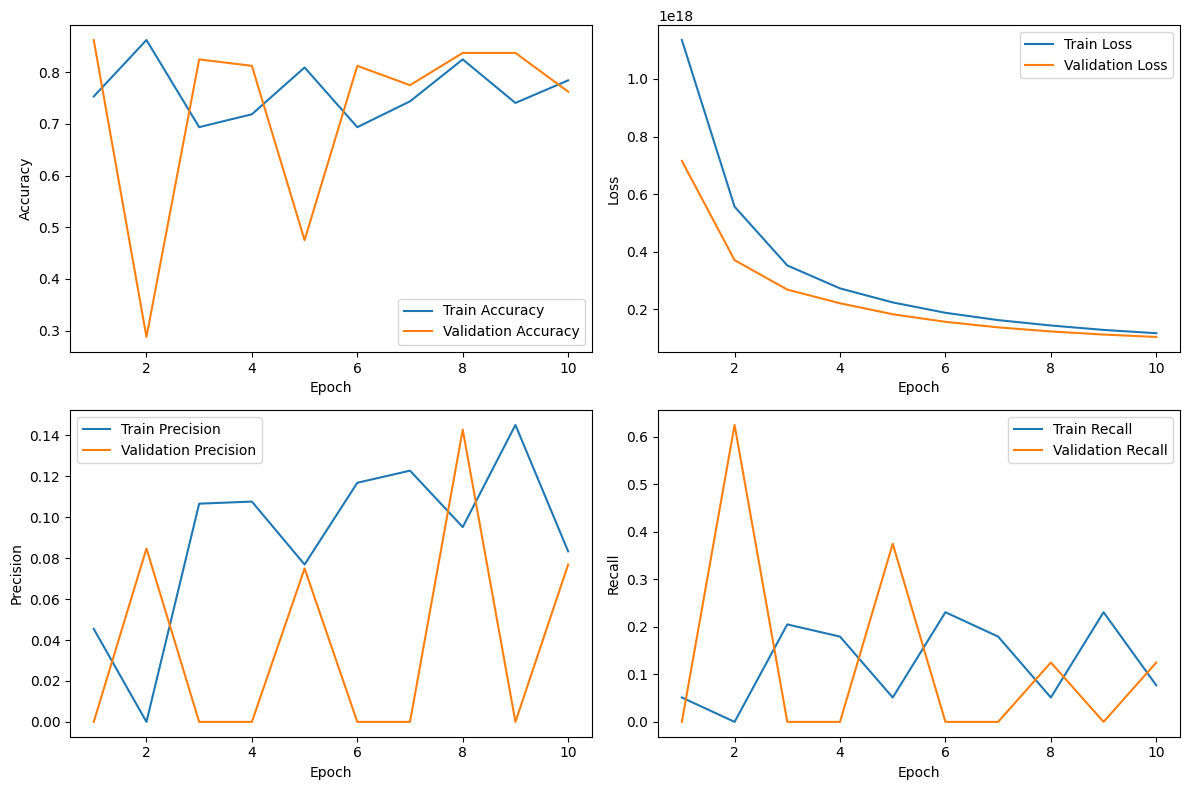

In [21]:
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_roc_aucs, val_roc_aucs = [], []

num_epochs = 10
epochs = list(range(1, num_epochs + 1))

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    all_labels, all_preds = [], []

    for batch in train_loader:
        inputs, labels = batch['input_ids'], batch['label']
        optimizer.zero_grad()

        logits, reconstructed = model(inputs)
        loss_reconstruction = criterion_reconstruction(reconstructed, inputs)
        loss_classification = criterion_classification(logits, labels)
        loss = loss_reconstruction + loss_classification

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_roc_auc = roc_auc_score(all_labels, all_preds)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_roc_aucs.append(train_roc_auc)

    model.eval()
    val_loss, all_val_labels, all_val_preds = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input_ids'], batch['label']
            logits, reconstructed = model(inputs)

            loss_reconstruction = criterion_reconstruction(reconstructed, inputs)
            loss_classification = criterion_classification(logits, labels)
            loss = loss_reconstruction + loss_classification
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_roc_auc = roc_auc_score(all_val_labels, all_val_preds)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_roc_aucs.append(val_roc_auc)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


...

...

...

на торче с эмбэдингами (озу не хватило)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd

class ShingleDataset(Dataset):
    def __init__(self, data, max_length=130):
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        shingle_ids = [int(shingle) for shingle in item['shingle_id']]

        input_ids = torch.zeros(self.max_length, dtype=torch.long)
        input_ids[:len(shingle_ids)] = torch.tensor(shingle_ids[:self.max_length], dtype=torch.long)

        label = int(item['target'])
        return {'input_ids': input_ids, 'label': torch.tensor(label, dtype=torch.long)}

file_paths = ['/content/parts/split_file_0.jsonl', '/content/parts/split_file_1.jsonl']
dataframes = []
for file_path in file_paths:
    data = pd.read_json(file_path, lines=True)
    reshaped_data = [{'shingle_id': row['shingles'], 'target': int(row['target'])} for _, row in data.iterrows()]
    reshaped_df = pd.DataFrame(reshaped_data)
    dataframes.append(reshaped_df)

full_data = pd.concat(dataframes, ignore_index=True)

train_data = full_data.sample(frac=0.8, random_state=42)

max_shingle_id = max(max(int(shingle) for shingle in row['shingle_id']) for _, row in train_data.iterrows())
vocab_size = max_shingle_id + 1

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_length, output_dim=2):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        if torch.max(x) >= self.embedding.num_embeddings:
            raise ValueError("Input shingle_id exceeds vocabulary size.")

        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        logits = self.fc(x)

        return logits

In [ ]:
train_dataset = ShingleDataset(train_data, max_length=130)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = TransformerClassifier(vocab_size=vocab_size, embed_dim=64, num_heads=4, num_layers=3, max_length=130)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch['input_ids'], batch['label']
        optimizer.zero_grad()

        logits = model(inputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")